## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px


# Remove warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
# Opening JSON file
f = open('/content/drive/MyDrive/Colab Notebooks/Automatic Ticket Classification-Case Study/Dataset/complaints-2021-05-14_08_16.json',)
# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [57]:
df.shape

(78313, 22)

In [58]:

# Inspect the dataframe to understand the given data.
df.head(10)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [59]:
#print the column names
list(df.columns)


['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [61]:
#Assign new column names
df.columns=[re.sub('^_','',col) for col in df.columns]
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [63]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace("", np.nan, inplace=True)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [65]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [66]:
df.shape

(21072, 22)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  object 


In [68]:
#dropping column 'company_public_response' as only 2 not null values are there
df = df.drop('company_public_response', axis=1)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21072 entries, 1 to 78312
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  object 


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [70]:
# Write your function here to clean the text and remove all the unnecessary elements.
def textclean(text):
    #Make the text lowercase
    text=text.lower()

    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)

    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)

    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text

In [71]:
#Write your function to Lemmatize the texts
def textlemmatize(text):
    lemmas = []
    document = nlp(text)
    for word in document:
        lemmas.append(word.lemma_)
    return " ".join(lemmas)

In [76]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df['clean_complaint']= df['complaint_what_happened'].apply(lambda x: textclean(x))
df["lemmatized_complaint"] =  df.apply(lambda x: textlemmatize(x['complaint_what_happened']), axis=1)
df_clean=df[['clean_complaint','lemmatized_complaint']]

In [77]:
df_clean.head()

,clean_complaint,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be XXXX XXXX and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in XX / xx/2018 an...
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / XX/2019 . however...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a XXXX x..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ 1600.00 } I ...


In [78]:
#Write your function to extract the POS tags
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
#lets extract only NN tags
def pos_tag(text):
  # write your code here
  text_blob = TextBlob(text)
  return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])



In [90]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')  # For tokenization
nltk.download('wordnet')  # For lemmatization
nltk.download('stopwords')  # For stop words removal

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [91]:

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1)

In [92]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,clean_complaint,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in XX / xx/2018 an...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a XXXX x...",try book ticket offer ticket card information ...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0, 0.5, 'No. of Complaints')

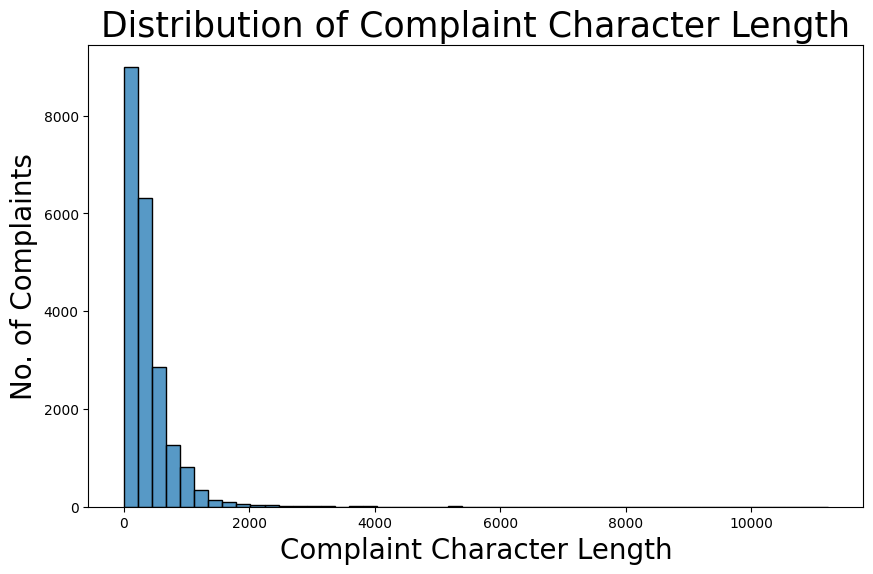

In [93]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=[10,6])
sns.histplot(data = [len(x) for x in df_clean['complaint_POS_removed']],bins=50)
plt.title('Distribution of Complaint Character Length', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

#### Find the top 40 words by frequency among all the articles after processing the text.

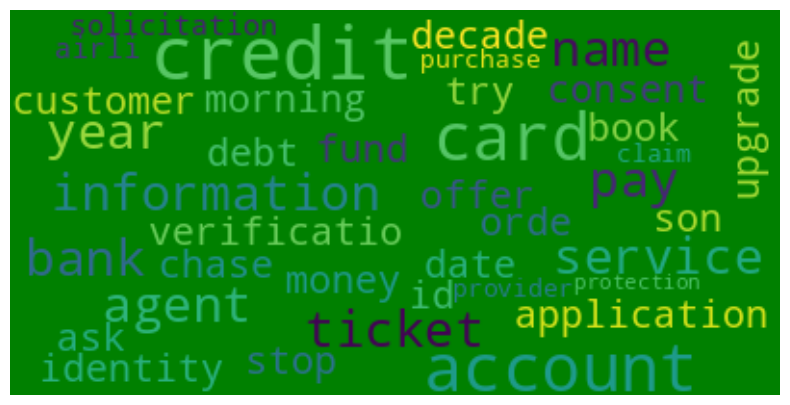

In [98]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='green',
                          stopwords=stop_words,
                          max_font_size=38,
                          max_words=38,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))


plt.figure(figsize=(10, 5))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [99]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [100]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [101]:
#Print the top 10 words in the unigram frequency
top_common_words = unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,account,46949
1,credit,31174
2,card,26780
3,xxxx,26516
4,payment,20911
5,bank,18456
6,time,16047
7,charge,14999
8,day,13141
9,money,11951


In [102]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [103]:
#Print the top 10 words in the bigram frequency
top_common_words = bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,11326
1,credit report,3749
2,xxxx xxxx,3156
3,account account,2797
4,customer service,2640
5,bank account,2284
6,check account,2010
7,card account,1607
8,account credit,1579
9,debit card,1560


In [104]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [105]:
#Print the top 10 words in the trigram frequency
top_common_words = trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,credit card account,1028
1,credit card company,901
2,credit card credit,549
3,charge credit card,517
4,xxxx xxxx xxxx,508
5,inquiry credit report,467
6,account credit card,453
7,card credit card,452
8,credit reporting agency,323
9,credit card charge,314


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [106]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [107]:
#All masked texts has been removed
df_clean.head(5)

,clean_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in XX / xx/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a XXXX x...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...


In [108]:
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [109]:
#Write your code here to initialise the TfidfVectorizer
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [110]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
doc_term_matrix=tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [111]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [112]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40) #write your code here

In [113]:
nmf_model.fit(doc_term_matrix)

NMF(n_components=5, random_state=40)

In [114]:

len(tfidf.get_feature_names_out())

6565

In [115]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'checking', 'business', 'transaction', 'number', 'xxxx', 'branch', 'day', 'deposit', 'fund', 'money', 'bank', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['chase', 'balance', 'year', 'letter', 'debt', 'application', 'limit', 'information', 'company', 'score', 'account', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['error', 'year', 'account', 'credit', 'auto', 'date', 'mortgage', 'pay', 'day', 'time', 'statement', 'fee', 'month', 'balance', 'payment']


TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'time', 'statement', 'service', 'fraud', 'claim', 'purchase', 'xxxx', 'merchant', 'dispute', 'transaction', 'fee', 'card', 'charge']


TOP 15 WORDS FOR TOPIC #4
['sale', 'information', 'foreclosure', 'house', 'time', 'document', 'rate', 'letter', 'year', 'property', 'modification', 'home', 'xxxx', 'mortgage', 'loan']




In [116]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_result = nmf_model.transform(doc_term_matrix)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)


array([4, 1, 1, ..., 3, 2, 2])

In [130]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1) #write your code to assign topics to each rows.

In [131]:
df_clean.shape

(21072, 5)

In [132]:
df_clean.head()

,clean_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in XX / xx/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a XXXX x...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [133]:
#Print the first 5 Complaint for each of the Topics
df_clean_first5=df_clean.groupby('Topic').head(5)
df_clean_first5.sort_values('Topic')
df_clean_first5.head()

,clean_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in XX / xx/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a XXXX x...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [134]:
#Create the dictionary of Topic names and Topics

#Replace Topics with Topic Names
df_clean.replace({'Topic':{0:"Bank Account services",
               1:"Credit card or prepaid card",
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}},inplace=True)

In [135]:
df_clean.head()

,clean_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in XX / xx/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...,Credit card or prepaid card
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a XXXX x...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,Credit card or prepaid card
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services


In [123]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [136]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [137]:
df_clean.shape

(21072, 5)

In [138]:
df_clean.head()

,clean_complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop service ask debt verificatio...,morning name stop service ask debt verificatio...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in XX / xx/2018 an...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / XX/2019 . however...,application identity consent service credit id...,application identity consent service credit id...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a XXXX x...",try book ticket offer ticket card information ...,try book ticket offer ticket card information ...,1
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ 1600.00 } I ...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [139]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['clean_complaint','Topic']]

In [140]:
training_data.shape

(21072, 2)

In [141]:
training_data.head()

,clean_complaint,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,1
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a xxxx xxxx ...",1
14,my grand son give me check for {$.} i deposit ...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [144]:

#Write your code to get the Vector count
count_vector=CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count=count_vector.fit_transform(training_data['clean_complaint'])

In [145]:
# Saving Word Vector on disk for later usage
import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [146]:
from sklearn.feature_extraction.text import TfidfTransformer
# Transform the word vector to tf-idf
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [147]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [149]:
# Train-Test split
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 27984)
y_train Shape: (15804,)
X_test Shape: (5268, 27984)
y_test Shape: (5268,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics





# Model 1 - Logistic Regression

In [150]:
from sklearn.linear_model import LogisticRegression
model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [151]:
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr,
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [152]:
lr_tuned = LogisticRegression(C=1,
                                  penalty='l1',
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

In [153]:
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9198436328446614

In [156]:
def model_eval(y_test, y_pred, model_name):

    # print classification report of classifier
    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))

    return

In [157]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.92      0.94      0.93      1297
Credit card or prepaid card       0.91      0.92      0.92      1264
                     Others       0.93      0.93      0.93       576
    Theft/Dispute Reporting       0.92      0.90      0.91      1146
              Mortgage/Loan       0.92      0.91      0.92       985

                   accuracy                           0.92      5268
                  macro avg       0.92      0.92      0.92      5268
               weighted avg       0.92      0.92      0.92      5268



In [158]:
# Create a dataframe to store F1 Scores of all models we will build
f1_summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score': round(f1_lr, 2)}])
f1_summary

,Model,F1 Score
0,Logistic Regression,0.92


# Model 2  - Decision Tree

In [159]:
from sklearn.tree import DecisionTreeClassifier
model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [160]:
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],

}

grid_dt = GridSearchCV(estimator=dt,
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


In [161]:
dt_tuned = DecisionTreeClassifier(criterion='gini',
                                      max_depth=25,
                                      min_samples_leaf=15,
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [162]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7895879152093848

In [163]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.80      0.83      0.82      1297
Credit card or prepaid card       0.82      0.82      0.82      1264
                     Others       0.78      0.76      0.77       576
    Theft/Dispute Reporting       0.73      0.72      0.73      1146
              Mortgage/Loan       0.80      0.80      0.80       985

                   accuracy                           0.79      5268
                  macro avg       0.79      0.79      0.79      5268
               weighted avg       0.79      0.79      0.79      5268



In [164]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Decision Tree', round(f1_dt, 2)]
f1_summary

,Model,F1 Score
0,Logistic Regression,0.92
1,Decision Tree,0.79


# Model 3  - Random Forest

In [165]:
from sklearn.ensemble import RandomForestClassifier
# Run the Logistic Regression model with default parameters
model_name = 'RANDOM FOREST'
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

In [166]:
# Calculate F1 Score of tuned model using weighted average method
f1_rfc = f1_score(y_test, y_pred_rfc, average="weighted")
f1_rfc

0.6831761735746643

In [167]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_rfc, model_name)

CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.69      0.93      0.79      1297
Credit card or prepaid card       0.65      0.86      0.74      1264
                     Others       1.00      0.03      0.07       576
    Theft/Dispute Reporting       0.80      0.69      0.74      1146
              Mortgage/Loan       0.84      0.71      0.76       985

                   accuracy                           0.72      5268
                  macro avg       0.79      0.64      0.62      5268
               weighted avg       0.76      0.72      0.68      5268



In [168]:
# Update the summary table
f1_summary.loc[len(f1_summary.index)] = ['Random Forest', round(f1_rfc, 2)]
f1_summary

,Model,F1 Score
0,Logistic Regression,0.92
1,Decision Tree,0.79
2,Random Forest,0.68


#Logistic Regression model is performing best with F1 score : 0.92